# Analysis 2 - Manipulability analysis

For this project, we also looked at the manipulability of the voting rules we introduced in the previous notebook. More precisely, we wanted to see if **using ordinal extensions** with our voting rules would lower the degree of manipulability. 

That's what we are going to see in this notebook, using the case of one of my favorite rules : **SVDNash**.

We analysed **two kinds** of manipulation :

  * **Single-voter manipulation**
  * **Coalition trivial manipulation**
  
I will explain these different manipulations in their respective sections.

In [1]:
import numpy as np
import embedded_voting as ev
import matplotlib.pyplot as plt
np.random.seed(54036556)

First of all, we **create a random profile** with three groups of voter of the same size.

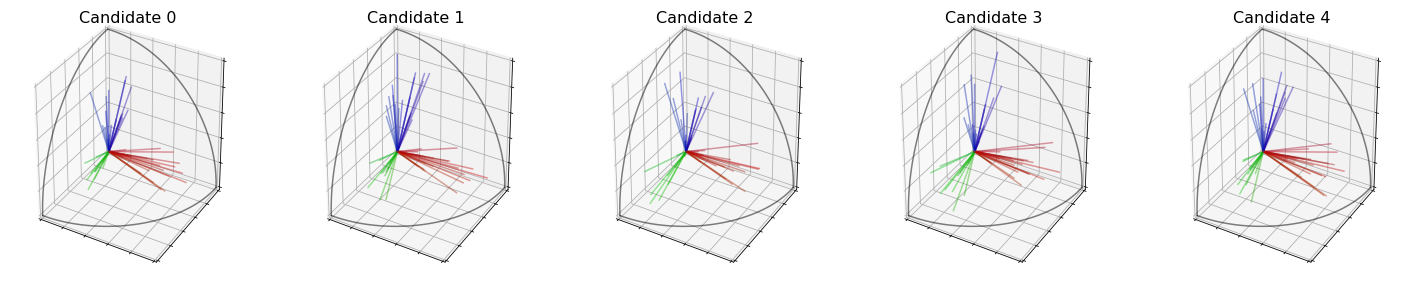

In [2]:
generator = ev.ProfileGenerator(50, 5, 3)
profile = generator(polarisation=0.4, coherence=0.2)
profile.plot_candidates()

## Single-voter manipulation

The **single-voter manipulation** is easy to understand.

Let's say the winner of an election is candidate $c_{w}$ and some voter $v_i$ prefers candidate $c_j$ to $c_w$ (i.e. $c_j >_i c_w$). Then, $v_i$ can **manipulate the election** by putting $c_j$ first (even if it's not his favorite candidate) and $c_w$ last. More generally, if $v_i$ can change his preferences so that $c_j$ becomes the winner instead of $c_w$, then $v_i$ can manipulate the election for $c_j$.

The questions we want to ask :

   * **What proportion** of the population can manipulate the election?
   * What is the **average welfare** obtained after manipulation of the election by a voter?
   * What is the **worst welfare** obtained after manipulation of the election by a voter?
   

### No extensions

Let's create an election using the rule **SVDNash**. The winner is candidate $c_4$.

In [3]:
election = ev.SVDNash(profile)
print("Winner : ", election.winner_)
print("Ranking : ", election.ranking_)
print("Welfare : ", election.welfare_)

Winner :  1
Ranking :  [1, 4, 3, 0, 2]
Welfare :  [0.2584856861235262, 1.0, 0.0, 0.8330911913618235, 0.9655311531545574]


With the class *<tt>SingleVoterManipulation</tt>*, I can answer the different questions about **the manipulability**.

To do so, when $v_i$ manipulates as explained above, we only set the score of the candidate $c_j$ to $1$ and every other score is set to $0$. It will work for **every monotonic rule** (which is the case of every rule we introduced).

For instance, in our election, $38\%$ of the voters **can** manipulate the election, and the **worst welfare** that can be attained is the welfare of candidate $c_1$, which is **ranked second**.

In [4]:
manipulation = ev.SingleVoterManipulation(profile, election)
print("Is manipulable : ", manipulation.is_manipulable_)
print("Proportion of manipulators : ", manipulation.prop_manipulator_)
print("Average welfare after manipulation : ", manipulation.avg_welfare_)
print("Worst welfare after manipulation : ", manipulation.worst_welfare_)

Is manipulable :  True
Proportion of manipulators :  0.54
Average welfare after manipulation :  0.9707916257600424
Worst welfare after manipulation :  0.8330911913618235


### Extensions

For **ordinal extension** (using *rankings*), we cannot use the above class, because if we set the score of every candidate to $0$, we cannot rank the candidates anymore (they have the same score). 

In the general case, we need to **test every possible ranking** for each voter. However, for some extension (*borda, k-approval, instant runoff*), we implemented **faster algorithms** for this.

For instance, with the **Borda extension** :

In [5]:
ordinal_election = ev.BordaExtension(profile=profile, rule=ev.SVDNash())
print("Winner : ", ordinal_election.winner_)
print("Ranking : ", ordinal_election.ranking_)
print("Welfare : ", ordinal_election.welfare_)

Winner :  4
Ranking :  [4, 1, 3, 0, 2]
Welfare :  [0.2065247445204463, 0.9713722436698475, 0.0, 0.8274129946722679, 1.0]


Now, if we test the manipulability with *<tt>SingleVoterManipulationExtension</tt>* class, it goes down to $0$, with a worst welfare of $1$!

In [6]:
ordinal_manipulation = ev.SingleVoterManipulationExtension(profile, extension=ordinal_election, rule=election)
print("Is manipulable : ", ordinal_manipulation.is_manipulable_)
print("Proportion of manipulators : ", ordinal_manipulation.prop_manipulator_)
print("Average welfare after manipulation : ", ordinal_manipulation.avg_welfare_)
print("Worst welfare after manipulation : ", ordinal_manipulation.worst_welfare_)

Is manipulable :  True
Proportion of manipulators :  0.4
Average welfare after manipulation :  0.9793186918927345
Worst welfare after manipulation :  0.9655311531545574


However, the above cell takes a lot of time (around $15$ seconds). Using the specific class *<tt>SingleVoterManipulationBorda</tt>*, this computation time can be reduced to $0.5$ seconds.

In [7]:
borda_manipulation = ev.SingleVoterManipulationBorda(profile, rule=election)
print("Is manipulable : ", borda_manipulation.is_manipulable_)
print("Proportion of manipulators : ", borda_manipulation.prop_manipulator_)
print("Average welfare after manipulation : ", borda_manipulation.avg_welfare_)
print("Worst welfare after manipulation : ", borda_manipulation.worst_welfare_)

Is manipulable :  True
Proportion of manipulators :  0.4
Average welfare after manipulation :  0.9793186918927345
Worst welfare after manipulation :  0.9655311531545574


Using **3-Approval**, we obtain $2\%$ of manipulators (only one voter, actually).

In [8]:
approval_manipulation = ev.SingleVoterManipulationKApp(profile, k=3, rule=election)
print("Is manipulable : ", approval_manipulation.is_manipulable_)
print("Proportion of manipulators : ", approval_manipulation.prop_manipulator_)
print("Average welfare after manipulation : ", approval_manipulation.avg_welfare_)
print("Worst welfare after manipulation : ", approval_manipulation.worst_welfare_)

Is manipulable :  False
Proportion of manipulators :  0.0
Average welfare after manipulation :  0.9655311531545575
Worst welfare after manipulation :  0.9655311531545574


Using **Instant Runoff**, the profile is not manipulable:

In [9]:
irv_manipulation = ev.SingleVoterManipulationIRV(profile, rule=election)
print("Is manipulable : ", irv_manipulation.is_manipulable_)
print("Proportion of manipulators : ", irv_manipulation.prop_manipulator_)
print("Average welfare after manipulation : ", irv_manipulation.avg_welfare_)
print("Worst welfare after manipulation : ", irv_manipulation.worst_welfare_)

Is manipulable :  True
Proportion of manipulators :  0.22
Average welfare after manipulation :  0.8698111292622224
Worst welfare after manipulation :  0.8330911913618235


## Coalition manipulation

The second kind of manipulation that is easy to compute and represent is the **coalition manipulation**. More specifically, is there a **trivial manipulation by a coalition**?

Let's say that the winner of the election is the candidate $c_w$ and let's name $V(j)$ the group of voters that prefer some candidate $c_j$ to the winner $c_w$:

$$
V(j) = \{ v_i | c_j >_i c_w\}
$$

Let's say now that all these voters set $c_j$ first and $c_w$ last. Is $c_j$ **the new winner** of the election ? If the answer is **yes**, then the profile is manipulable by a trivial coalition.

Obviously, if the profile is **manipulable by a single voter**, then it is also **manipulable by a coalition**.

### No extensions

When we don't use any extension, the profile is **very manipulable**. Indeed, every candidate can be elected after a trivial manipulation. 

Consequently, the **worst Nash welfare** attainable is $0$.

In [10]:
manipulation = ev.ManipulationCoalition(profile, election)
print("Is manipulable : ", manipulation.is_manipulable_)
print("Worst welfare after manipulation : ", manipulation.worst_welfare_)

Is manipulable :  True
Worst welfare after manipulation :  0.0


### Extensions

However, it **is a bit better** when we use an ordinal extension. You can use the general class *<tt>ManipulationCoalitionExtension</tt>* or the specific classes for *Borda*, *k-Approval* and *Instant runoff*. However, they use the same algorithm.

As you can see, using **Borda** extension, the profile is **still manipulable**, but the **worst Nash welfare** attainable is $0.51$, which is better than $0$. 

In [11]:
borda_extension = ev.BordaExtension(profile=profile, rule=ev.SVDNash())
borda_manipulation = ev.ManipulationCoalitionExtension(profile, borda_extension, election)
# manipulation = ev.ManipulationCoalitionBorda(profile, election)
print("Is manipulable : ", borda_manipulation.is_manipulable_)
print("Worst welfare after manipulation : ", borda_manipulation.worst_welfare_)

Is manipulable :  True
Worst welfare after manipulation :  0.2584856861235262


Using **3-Approval**, the **worst Nash welfare** is now equal to $0.92$, which is even better.

In [12]:
kapp_manipulation = ev.ManipulationCoalitionKApp(profile=profile, k=3, rule=election)
print("Is manipulable : ", kapp_manipulation.is_manipulable_)
print("Worst welfare after manipulation : ", kapp_manipulation.worst_welfare_)

Is manipulable :  True
Worst welfare after manipulation :  0.8330911913618235


Finally, with **Instant Runoff voting**, the profile is **not manipulable anymore**!

In [13]:
irv_manipulation = ev.ManipulationCoalitionIRV(profile, rule=election)
print("Is manipulable : ", irv_manipulation.is_manipulable_)
print("Worst welfare after manipulation : ", irv_manipulation.worst_welfare_)

Is manipulable :  True
Worst welfare after manipulation :  0.8330911913618235


## Manipulation maps

However, we cannot really judge a rule or an extension on one example. That's why we propose functions to show **manipulation maps** for some rule.

A map consists of an image of size $s \times s$ such that each pixel represents **one test**. A dark pixel represents a $0$ and a yellow pixel represents a $1$.

Moreover, we use a **parametric profile** for each test and we vary the *orthogonality* and the *correlation* of the parametric profiles for each test: The more the pixel is on the right, the higher the *correlation*, and the more the pixel is on the top, the higher the *orthogonality*.

For each test, a new *<tt>scores_matrix</tt>* is randomly generated for the parametric profile.

### No extensions

For instance, if we do not use extensions, we can see that the profiles are not very manipulable by **single-voters**, and when this is the case, the **worst Nash welfare** is high.

In [14]:
generator = ev.ProfileGenerator(50, 6, 3)

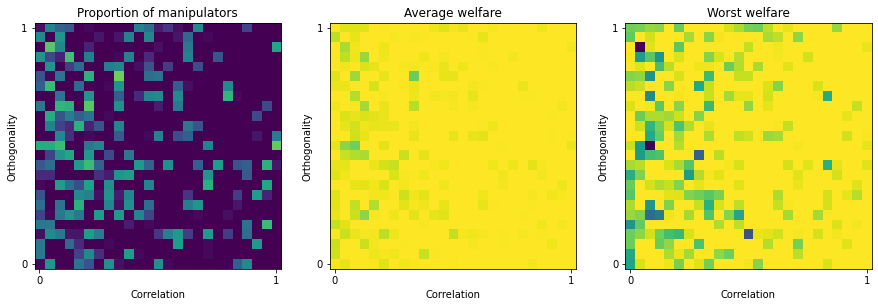

In [15]:
manipulation = ev.SingleVoterManipulation(profile, election)
res = manipulation.manipulation_map(map_size=25)

You can find **the data** used in the manipulation maps in the *output* of the function *<tt>manipulation_map()</tt>*.

In [16]:
res.keys()

dict_keys(['manipulator', 'worst_welfare', 'avg_welfare'])

However, almost every profile is manipulable **by trivial coalitions**, and often the **worst Nash welfare** is $0$:

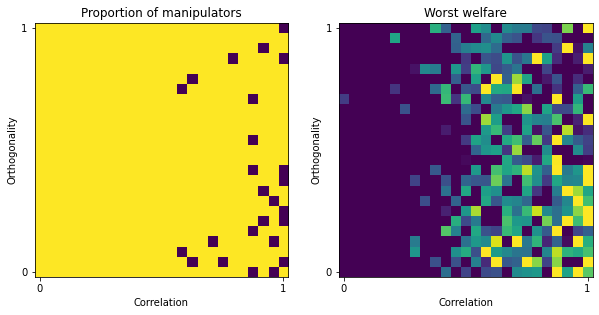

In [17]:
manipulation = ev.ManipulationCoalition(profile, election)
res = manipulation.manipulation_map(map_size=25)

Again, the output of the function contains the data of the manipulation maps.

In [18]:
res.keys()

dict_keys(['manipulator', 'worst_welfare'])

### Borda

With **Borda**, we improve a little bit the resistance to **manipulation by coalition**. However, we decrease the resistance to **manipulation by a single-voter**.

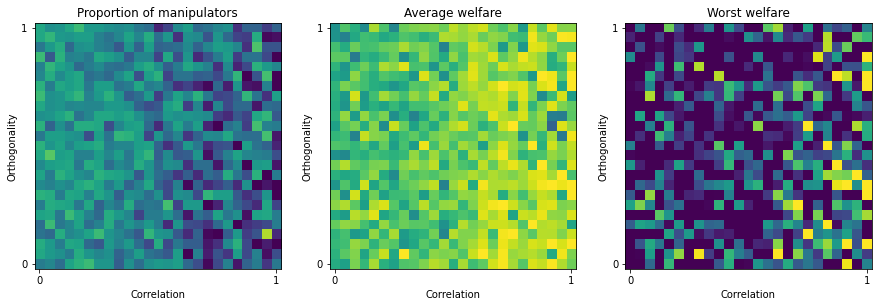

In [19]:
borda_manipulation = ev.SingleVoterManipulationBorda(profile, rule=election)
res = borda_manipulation.manipulation_map(map_size=25)

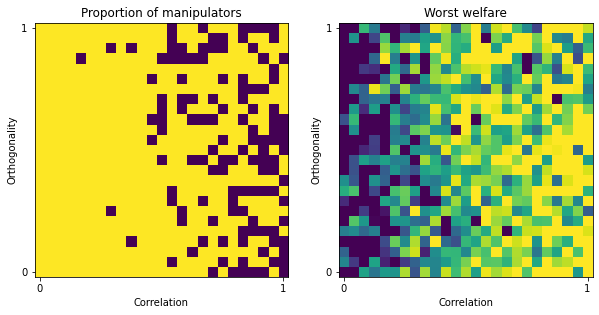

In [20]:
borda_manipulation = ev.ManipulationCoalitionBorda(profile, election)
res = borda_manipulation.manipulation_map(map_size=25)

### IRV

With **Instant Runoff**, we increase by **a lot** the resistance to **manipulation by coalition** without altering the resistance to **manipulation by a single voter**.

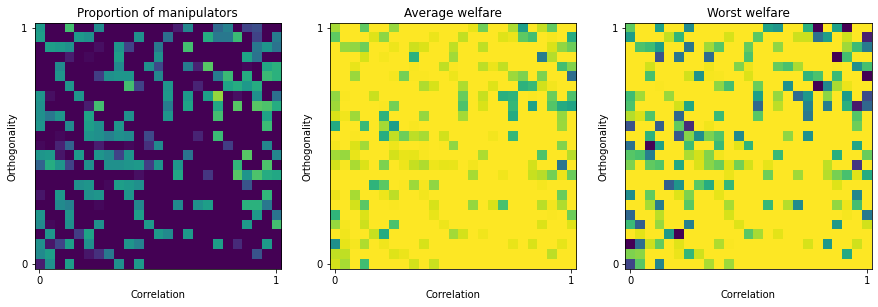

In [21]:
irv_manipulation = ev.SingleVoterManipulationIRV(profile, rule=election)
res = irv_manipulation.manipulation_map(map_size=25)

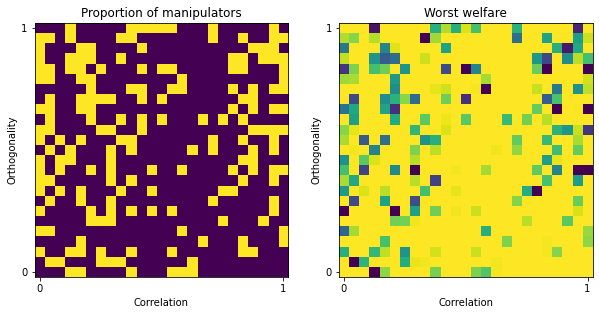

In [22]:
irv_manipulation = ev.ManipulationCoalitionIRV(profile, election)
res = irv_manipulation.manipulation_map(map_size=25)

### change map size

You can also plot **more detailed** manipulation maps by changing the <tt>map_size</tt> parameter. 

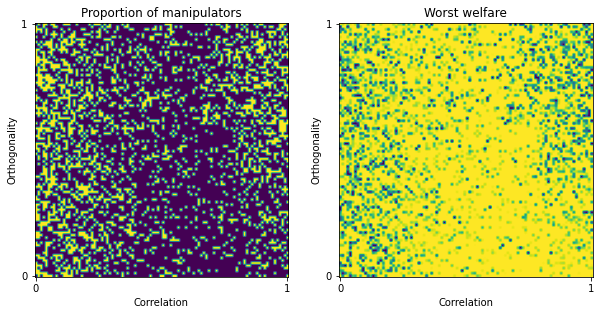

In [23]:
irv_manipulation = ev.ManipulationCoalitionIRV(profile, election)
res = irv_manipulation.manipulation_map(map_size=100)

### With particular scores matrix

In the previous plots, we changed the *<tt>scores_matrix</tt>* for each test (consequently, for each dot). You can modify that by specifying a matrix in the parameters of the function. It will use it for every test.

For instance, for **Instant Runoff**, you can see that the manipulation map heavily rely on this matrix: For some of them, there is a **dark spot** in the upper right corner (high *correlation* and high *orthogonality*).

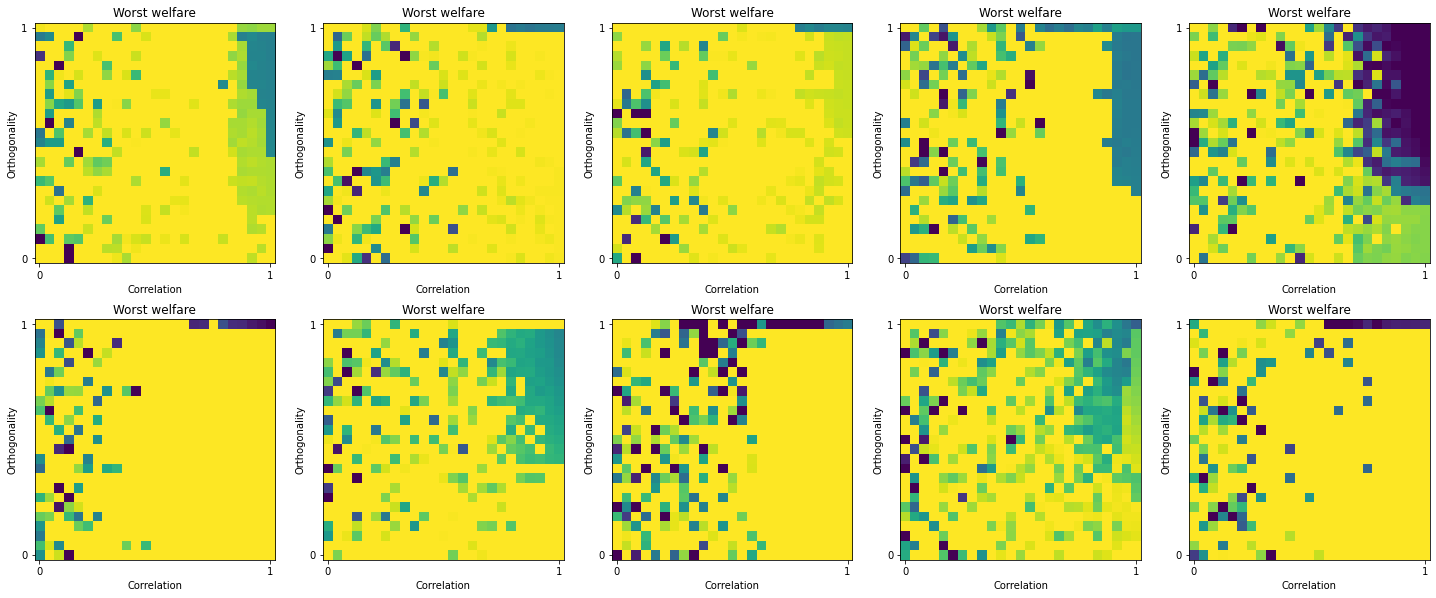

In [24]:
irv_manipulation = ev.ManipulationCoalitionIRV(profile, election)
fig = plt.figure(figsize=(25, 10))
map_size = 25
for i in range(10):
    res = irv_manipulation.manipulation_map(map_size=map_size, scores_matrix=np.random.rand(3, 5), show=False)
    image = res['worst_welfare']
    ev.create_map_plot(fig, image, [2, 5, i+1], "Worst welfare")
